In [1]:
from skimage import io
from skimage.transform import resize
import math 
import pickle 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os 
import cv2 

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import numpy as np

def sigmoid(s):
    return 1/(1 + np.exp(-s))

def sigmoid_derv(s):
    return s * (1 - s)

def softmax(s):
    exps = np.exp(s - np.max(s, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)

def cross_entropy(pred, real):
    n_samples = real.shape[0]
    res = pred - real
    return res/n_samples

def error(pred, real):
    n_samples = real.shape[0]
    logp = - np.log(pred[np.arange(n_samples), real.argmax(axis=1)])
    loss = np.sum(logp)/n_samples
    return loss

class MyNN:
    def __init__(self, x, y):
        self.x = x
        neurons = 128
        self.lr = 0.07
        ip_dim = x.shape[1]
        op_dim = y.shape[1]

        self.w1 = np.random.randn(ip_dim, neurons)
        self.b1 = np.zeros((1, neurons))
        self.w2 = np.random.randn(neurons, op_dim)
        self.b2 = np.zeros((1, op_dim))
        self.y = y

    def feedforward(self):
        z1 = np.dot(self.x, self.w1) + self.b1
        self.a1 = sigmoid(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = softmax(z2)
        
    def backprop(self):
        loss = error(self.a2, self.y)
        # print('Error :', loss)
        a2_delta = cross_entropy(self.a2, self.y) # w2
        z1_delta = np.dot(a2_delta, self.w2.T)
        a1_delta = z1_delta * sigmoid_derv(self.a1) # w1

        self.w2 -= self.lr * np.dot(self.a1.T, a2_delta)
        self.b2 -= self.lr * np.sum(a2_delta, axis=0, keepdims=True)
        self.w1 -= self.lr * np.dot(self.x.T, a1_delta)
        self.b1 -= self.lr * np.sum(a1_delta, axis=0)

    def predict(self, data):
        predected = []
        for i in data:
            self.x = i
            self.feedforward()
            predected.append(self.a2.argmax())
        return predected


# https://towardsdatascience.com/neural-networks-from-scratch-easy-vs-hard-b26ddc2e89c7

In [4]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = resize(io.imread(os.path.join(folder,filename)),(64,64),anti_aliasing=True,preserve_range=True)
        if img is not None:
            images.append(img)
    return np.array(images)

In [6]:
path = 'content/drive/MyDrive/segmentation_WBC/SVM_Segmentation/'

outerCells  = load_images_from_folder('/content/drive/MyDrive/segmentation_WBC/SVM_Segmentation/outer_cell')
innerCells  = load_images_from_folder('/content/drive/MyDrive/segmentation_WBC/SVM_Segmentation/inner_cell')
backgrounds = load_images_from_folder('/content/drive/MyDrive/segmentation_WBC/SVM_Segmentation/background')

In [7]:
x_train = []

for j in range(len(outerCells)):
    x_train.append(outerCells[j])
    x_train.append(innerCells[j])
    x_train.append(backgrounds[j])

x_train = np.array(x_train)


In [8]:
feature_vectors = []
for i in x_train:
    feature_vectors.append(np.float32(i)/255)

feature_vectors = np.array(feature_vectors)

In [9]:
data = pd.DataFrame(columns=['R','G','B','class'])
for i in range(len(x_train)):
    if (i) % 3 == 0:
        data = data.append(pd.DataFrame(np.insert(feature_vectors[i].reshape(-1,3),3,1,axis=1),columns=['R','G','B','class']))
    if (i) % 3 == 1:
        data = data.append(pd.DataFrame(np.insert(feature_vectors[i].reshape(-1,3),3,2,axis=1),columns=['R','G','B','class']))
    if (i) % 3 == 2:
        data = data.append(pd.DataFrame(np.insert(feature_vectors[i].reshape(-1,3),3,3,axis=1),columns=['R','G','B','class']))
data = data.reset_index()
data = data.drop(['index'],axis=1)

In [10]:
y = data['class'].values
x = data.iloc[:,[0,1,2]].values

x.shape

(368640, 3)

In [11]:
oneHot = OneHotEncoder()
y = oneHot.fit_transform(y.reshape(-1,1)).toarray()
y.shape

(368640, 3)

In [12]:
model = MyNN(x, np.array(y))

epochs = 50
for x in range(epochs):
    model.feedforward()
    model.backprop()


In [21]:
#with open('SNN_Model_Pickle','wb') as f:
#    pickle.dump(model,f)

In [17]:
x_tested = io.imread('/content/drive/MyDrive/segmentation_WBC/Dataset 2/006.bmp')
pixel_values = np.float32(x_tested)/255
x_tested = np.array(pixel_values)

testclass = pd.DataFrame(columns = ['R','G','B'])
testclass = testclass.append(pd.DataFrame(x_tested.reshape(-1,3),columns = ['R','G','B']))

x_tested = testclass.iloc[:,:].values

y_pred = model.predict(x_tested)
y_pred = np.array(y_pred)

In [18]:
cluster_mean  = []
cluster_mean2 = []
cluster_mean3 = []

for i in range(len(x_tested)):
  if y_pred[i] == 0:
    cluster_mean.append(x_tested[i])
  if y_pred[i] == 1:
    cluster_mean2.append(x_tested[i])
  if y_pred[i] == 2:
    cluster_mean3.append(x_tested[i])
  
cluster_mean = np.mean(cluster_mean,axis=0)
cluster_mean2 = np.mean(cluster_mean2,axis=0)
cluster_mean3 = np.mean(cluster_mean3,axis=0)


In [19]:
y_pred.reshape(-1,1)
y_mean = []
for i in y_pred:
    if i == 0:
        y_mean.append(cluster_mean)
    if i == 1:
        y_mean.append(cluster_mean2)
    if i == 2:
        y_mean.append(cluster_mean3)
        
y_mean = np.array(y_mean)

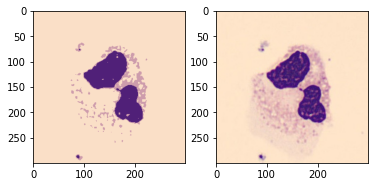

In [20]:
reshape_vale=int(math.sqrt(y_pred.shape[0]))

y_mean = y_mean.reshape(reshape_vale,reshape_vale,3)

plt.subplot(1,2,1)
plt.imshow(y_mean)

plt.subplot(1,2,2)
plt.imshow(io.imread('/content/drive/MyDrive/segmentation_WBC/Dataset 2/006.bmp'))